In [1]:
!pip install OWSLib
!pip install lxml

    100% |████████████████████████████████| 163kB 15.3MB/s ta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/a9/df/a9/e2cdd604deeb860e9fe5bec9a5099eeb7cde5fec6a7d08ca16
Successfully built OWSLib
    100% |████████████████████████████████| 5.7MB 9.5MB/s eta 0:00:01    17% |█████▋                          | 993kB 25.9MB/s eta 0:00:01


In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import ipywidgets as widgets
from owslib.wms import WebMapService
import requests
from io import BytesIO
import PIL
import numpy as np

def produce_img(wms, layer_name):
    layer = wms[layer_name]
    bbox = layer.boundingBoxWGS84
    img  = wms.getmap(layers = [layer_name],
#                 styles = ['visual_bright'],
                 srs = 'EPSG:4326',
                 bbox = bbox,
                 size = (300, 250),
                 format = 'image/jpeg',
                 transparent=True)
    return Image(img.read())


def get_legend(wms, layer_name):
    try:
        layer = wms[layer_name]
        legend_url = layer.styles['default']['legend']
        legend_response = requests.get(legend_url)
        legend_img = PIL.Image.open(BytesIO(legend_response.content))
        return legend_img
    except KeyError:
        return None

def get_center(extent):
    extent = list(extent)
    min_long = extent[0]
    min_lat = extent[1]
    max_long = extent[2]
    max_lat = extent[3]
    return [np.mean([min_long, max_long]), np.mean([min_lat, max_lat])]

def format_coord(bound_tuple):
    bound_list = list(bound_tuple)
    min_coord = bound_list[:2][::-1]
    max_coord = bound_list[2:][::-1]
    return[min_coord, max_coord]

see example https://web2.nbmg.unr.edu/ArcGIS/services/CO_Data/COActiveFaults/MapServer/WMSServer?request=GetCapabilities&service=WMS

In [3]:
wms_url = 'https://web2.nbmg.unr.edu/ArcGIS/services/CO_Data/COActiveFaults/MapServer/WMSServer?request=GetCapabilities&service=WMS'

In [4]:
wms = WebMapService(wms_url)

In [5]:
layers = list(wms.contents)
menu = widgets.Dropdown(options = layers)
#the layer's name is called 0, ikr its bad
menu

Dropdown(options=('0',), value='0')

In [6]:
layer_img = produce_img(wms, menu.value)
legend_img = get_legend(wms, menu.value)

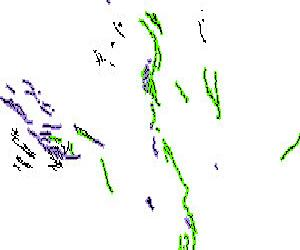

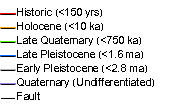

In [7]:
display(layer_img)
display(legend_img)

Try to display the image on an interactive map

In [8]:
import folium

Grab the layer that the user selects

In [9]:
lyr = wms[menu.value]

retrieves the imagery and relavent spatial information (bounding box)

In [10]:
img  = wms.getmap(layers = ['0'],
#                 styles = ['visual_bright'],
                 srs = 'EPSG:4326',
                 bbox = lyr.boundingBoxWGS84,
                 size = (300, 250),
                 format = 'image/png',
                 transparent=True)
bbox = format_coord(lyr.boundingBoxWGS84)

write the imagery into a local png file(don't know how to pass in other format of input yet)

In [11]:
file_name = lyr.id + '.png'
out = open(file_name, 'wb')
out.write(img.read())
out.close() 

Create the overlay raster image object in folium

In [12]:
overlay_img = folium.raster_layers.ImageOverlay(
    name = menu.value,
    image = file_name,
    bounds = bbox
)

Find the zoom location of the map by calculating the center of the bounding box

In [13]:
center = get_center(lyr.boundingBoxWGS84)

create the map with that center and custom width, height and starting zoom level

In [14]:
width, height = 650, 500
m = folium.Map(location = center[::-1],
                  #tiles='Stamen Toner',
                  width=width,
                  height=height,
                  zoom_start=8)

Add the imagery layer to the map

In [15]:
overlay_img.add_to(m)
m